### importing libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datasist.structdata import detect_outliers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

from geopy.geocoders import Nominatim
from geopy import distance
from geopy.distance import great_circle

### loading data 

In [2]:
df = pd.read_excel('Data_Train.xlsx')
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882



### Preprocessing

In [3]:
### concatenate  Date_of_Journey & Dep_Time
df['Date_of_Journey'] = df['Date_of_Journey'] + " " + df['Dep_Time']
df.drop('Dep_Time', axis=1 , inplace=True)

In [4]:
### Convert dtype to datetime64
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y %H:%M', errors='coerce')

In [5]:
### makeing function to clean columns 
def extract_H_of_Arrival(x):
    return x[:5]

def GetArrivalDay(n,Category) : 
    if len(n.split()) == 1 : 
        return 'none'
    else : 
        if Category == 'D' : 
            return n.split()[1]
        else : 
            return n.split()[2]


df['Hour_of_Ariving'] = df['Arrival_Time'].apply(extract_H_of_Arrival)
df['day_of_Ariving'] =  df['Arrival_Time'].apply(lambda x : GetArrivalDay(x,'D'))
df['Month_of_Ariving'] =  df['Arrival_Time'].apply(lambda x : GetArrivalDay(x,'M'))

df.drop(['Arrival_Time'] , axis=1 , inplace=True)

In [6]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Hour_of_Ariving,day_of_Ariving,Month_of_Ariving
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,01:10,22,Mar
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,13:15,none,none


In [7]:
### replace Delhi by New Delhi
df['Source'] = df['Source'].replace("Delhi" , "New Delhi")
df['Destination'] = df['Destination'].replace("Delhi" , "New Delhi")

In [8]:
### dictionary to convert Total_Stops to numerical columns
change = {'non-stop':0 ,'1 stop':1 ,'2 stops':2 ,'3 stops':3 ,'4 stops':4}
df['Total_Stops'] = df['Total_Stops'].map(change)

In [9]:
### extract time from columns and clean and make feature extraction

def extract_H(x):
    return x[:3].split('h')[0]
def extract_M(x):
    return x[3:].split('m')[0]
df['Duration_h'] = df['Duration'].apply(extract_H)
df['Duration_m'] = df['Duration'].apply(extract_M) 
df['du_h']=df['Duration_h'].replace('5m',5)
df['du_m']=df['Duration_m'].replace('',0)
df.drop(['Duration','Duration_h','Duration_m'],axis = 1 , inplace=True)
df[['du_h', 'du_m']] = df[['du_h', 'du_m']].astype('float')
df['Duration_in_mintues'] = (df['du_h']*60) + df['du_m']
df.drop(['du_h', 'du_m'] , axis = 1 , inplace = True)
df['Month_of_Date_of_Journey'] = df['Date_of_Journey'].dt.month
df['Month_Name_of_Date_of_Journey'] = df['Date_of_Journey'].dt.month_name()
df['Day_number_of_Date_of_Journey'] = df['Date_of_Journey'].dt.day
df['Day_Name_of_Date_of_Journey'] = df['Date_of_Journey'].dt.day_name()
df['Hour_Date_of_Journey'] = df['Date_of_Journey'].dt.hour

In [10]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Hour_of_Ariving,day_of_Ariving,Month_of_Ariving,Duration_in_mintues,Month_of_Date_of_Journey,Month_Name_of_Date_of_Journey,Day_number_of_Date_of_Journey,Day_Name_of_Date_of_Journey,Hour_Date_of_Journey
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,01:10,22,Mar,170.0,3,March,24,Sunday,22
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,13:15,none,none,445.0,5,May,1,Wednesday,5


In [11]:
def GetDiff(a,b) : 
    if b!= 'none' : 
        return int(b) - int(a)
df['DayDiff'] = df.apply(lambda x : GetDiff(x.Day_number_of_Date_of_Journey,x.day_of_Ariving) ,axis=1)

In [12]:
df['DayDiff'].unique()

array([-2., nan,  1.,  4.,  2., -5., -1.])

In [13]:
df['DayDiff'].value_counts()

 1.0    4143
-2.0      84
 4.0      52
 2.0      51
-5.0       4
-1.0       1
Name: DayDiff, dtype: int64

In [14]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Hour_of_Ariving,day_of_Ariving,Month_of_Ariving,Duration_in_mintues,Month_of_Date_of_Journey,Month_Name_of_Date_of_Journey,Day_number_of_Date_of_Journey,Day_Name_of_Date_of_Journey,Hour_Date_of_Journey,DayDiff
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,01:10,22,Mar,170.0,3,March,24,Sunday,22,-2.0
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,13:15,none,none,445.0,5,May,1,Wednesday,5,NaN


In [15]:
df.drop(['day_of_Ariving','Month_of_Ariving','DayDiff'],axis=1,inplace=True)

In [16]:
df['ArrivalHour'] = df['Hour_of_Ariving'].apply(lambda x : x.split(':')[0])
df.drop(['Hour_of_Ariving'],axis=1,inplace=True)

In [17]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_in_mintues,Month_of_Date_of_Journey,Month_Name_of_Date_of_Journey,Day_number_of_Date_of_Journey,Day_Name_of_Date_of_Journey,Hour_Date_of_Journey,ArrivalHour
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,170.0,3,March,24,Sunday,22,01
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,445.0,5,May,1,Wednesday,5,13


In [18]:
####  FEATURE EXTRACTION
def map_months(x):
    if x in [12, 1, 2]:
        return 'Winter'
    elif x in [3, 4, 5]:
        return 'Spring'
    elif x in [6, 7, 8]:
        return 'Summer'
    elif x in [9, 10, 11]:
        return 'Autumn'

def map_hours(x):
    if x in range(0, 13):
        return 'morning'
    elif x in range(13, 19):
        return 'afternoon'
    else:
        return 'evening'    

In [19]:
df['Season_of_Date_of_Journey'] = df['Month_of_Date_of_Journey'].apply(map_months)
    
df['Period_of_Date_of_Journey'] = df['Hour_Date_of_Journey'].apply(map_hours)    

In [20]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_in_mintues,Month_of_Date_of_Journey,Month_Name_of_Date_of_Journey,Day_number_of_Date_of_Journey,Day_Name_of_Date_of_Journey,Hour_Date_of_Journey,ArrivalHour,Season_of_Date_of_Journey,Period_of_Date_of_Journey
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,170.0,3,March,24,Sunday,22,01,Spring,evening
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,445.0,5,May,1,Wednesday,5,13,Spring,morning
2,Jet Airways,2019-06-09 09:25:00,New Delhi,Cochin,DEL → LKO → BOM → COK,2.0,No info,13882,1140.0,6,June,9,Sunday,9,04,Summer,morning
3,IndiGo,2019-05-12 18:05:00,Kolkata,Banglore,CCU → NAG → BLR,1.0,No info,6218,325.0,5,May,12,Sunday,18,23,Spring,afternoon
4,IndiGo,2019-03-01 16:50:00,Banglore,New Delhi,BLR → NAG → DEL,1.0,No info,13302,285.0,3,March,1,Friday,16,21,Spring,afternoon


In [21]:
#### FEATURE EXTRACTION
### EXTRACT DISTANCE BETWEEN  LOCATIONS BY GET LAT&LONG
geolocator = Nominatim(user_agent="MOUSA")
change = {'New Delhi':28.6138954 ,'Banglore':12.9587464 ,'Cochin':9.931308 ,'Kolkata':22.5414185,'Hyderabad':17.360589}
df['Destination_latitude'] = df['Destination'].map(change)
change = {'New Delhi':77.2090057 ,'Banglore':77.5573456 ,'Cochin':76.2674136 ,'Kolkata':88.35769124388872,'Hyderabad':78.4740613}
df['Destination_longitude'] = df['Destination'].map(change)
change = {'New Delhi':28.6138954 ,'Banglore':12.9587464 ,'Chennai':13.0836939 ,'Kolkata':22.5414185,'Mumbai':19.0785451}
df['Source_latitude'] = df['Source'].map(change)
change = {'New Delhi':28.6138954 ,'Banglore':12.9587464 ,'Chennai':80.270186 ,'Kolkata':22.5414185,'Mumbai':72.878176}
df['Source_longitude'] = df['Source'].map(change)
def get_dist(x):
    loc_1 = (x['Source_latitude'], x['Source_longitude'])
    loc_2 = (x['Destination_latitude'], x['Destination_longitude'])
    return great_circle(loc_1, loc_2).kilometers

df['miles'] = df.apply(get_dist, axis=1)
df['Speed_of_flight_kg/m'] = df['miles'] / df['Duration_in_mintues']

In [22]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_in_mintues,Month_of_Date_of_Journey,...,Hour_Date_of_Journey,ArrivalHour,Season_of_Date_of_Journey,Period_of_Date_of_Journey,Destination_latitude,Destination_longitude,Source_latitude,Source_longitude,miles,Speed_of_flight_kg/m
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,170.0,3,...,22,01,Spring,evening,28.613895,77.209006,12.958746,12.958746,6824.688064,40.145224
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,445.0,5,...,5,13,Spring,morning,12.958746,77.557346,22.541418,22.541418,5891.655652,13.239676
2,Jet Airways,2019-06-09 09:25:00,New Delhi,Cochin,DEL → LKO → BOM → COK,2.0,No info,13882,1140.0,6,...,9,04,Summer,morning,9.931308,76.267414,28.613895,28.613895,5372.037319,4.712313
3,IndiGo,2019-05-12 18:05:00,Kolkata,Banglore,CCU → NAG → BLR,1.0,No info,6218,325.0,5,...,18,23,Spring,afternoon,12.958746,77.557346,22.541418,22.541418,5891.655652,18.128171
4,IndiGo,2019-03-01 16:50:00,Banglore,New Delhi,BLR → NAG → DEL,1.0,No info,13302,285.0,3,...,16,21,Spring,afternoon,28.613895,77.209006,12.958746,12.958746,6824.688064,23.946274


In [23]:
set(df['Additional_Info'].unique())

{'1 Long layover',
 '1 Short layover',
 '2 Long layover',
 'Business class',
 'Change airports',
 'In-flight meal not included',
 'No Info',
 'No check-in baggage included',
 'No info',
 'Red-eye flight'}

In [24]:
df['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [25]:
df['Meal Included'] = df['Additional_Info'].apply(lambda x : 1 if x != 'In-flight meal not included' else 0)
df['Meal Included'].value_counts()

1    8701
0    1982
Name: Meal Included, dtype: int64

In [26]:
df['Additional_Info'].replace('No Info','No info',inplace=True)

In [27]:
df['Additional_Info'].value_counts()

No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [28]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Total_Stops', 'Additional_Info', 'Price', 'Duration_in_mintues',
       'Month_of_Date_of_Journey', 'Month_Name_of_Date_of_Journey',
       'Day_number_of_Date_of_Journey', 'Day_Name_of_Date_of_Journey',
       'Hour_Date_of_Journey', 'ArrivalHour', 'Season_of_Date_of_Journey',
       'Period_of_Date_of_Journey', 'Destination_latitude',
       'Destination_longitude', 'Source_latitude', 'Source_longitude', 'miles',
       'Speed_of_flight_kg/m', 'Meal Included'],
      dtype='object')

In [29]:
def FlightLength(n) : 
    if n < 120 : 
        return 'short'
    elif n < 480 : 
        return 'Medium'
    elif n < 600 : 
        return 'Long'
    else : 
        return 'Extreme Long'
    
    
df['FlightLength'] = df['Duration_in_mintues'].apply(lambda x  : FlightLength(x))
df['FlightLength'].value_counts()

Extreme Long    4759
Medium          4434
Long             869
short            621
Name: FlightLength, dtype: int64

In [30]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_in_mintues,Month_of_Date_of_Journey,...,Season_of_Date_of_Journey,Period_of_Date_of_Journey,Destination_latitude,Destination_longitude,Source_latitude,Source_longitude,miles,Speed_of_flight_kg/m,Meal Included,FlightLength
0,IndiGo,2019-03-24 22:20:00,Banglore,New Delhi,BLR → DEL,0.0,No info,3897,170.0,3,...,Spring,evening,28.613895,77.209006,12.958746,12.958746,6824.688064,40.145224,1,Medium
1,Air India,2019-05-01 05:50:00,Kolkata,Banglore,CCU → IXR → BBI → BLR,2.0,No info,7662,445.0,5,...,Spring,morning,12.958746,77.557346,22.541418,22.541418,5891.655652,13.239676,1,Medium


In [31]:
### DROP DUPLICATES
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

222


In [32]:
df.dropna(inplace=True)

### ANALYSIS AND VISUALIZATION

In [33]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize': [5, 5]}, font_scale=0.8)

<AxesSubplot:xlabel='count', ylabel='Airline'>

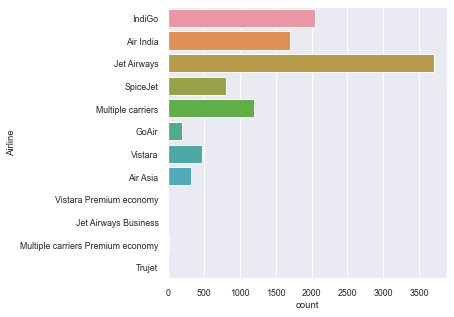

In [34]:
sns.countplot(y=df['Airline'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Source'>

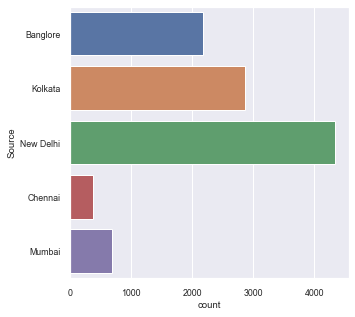

In [35]:
sns.countplot(y=df['Source'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Destination'>

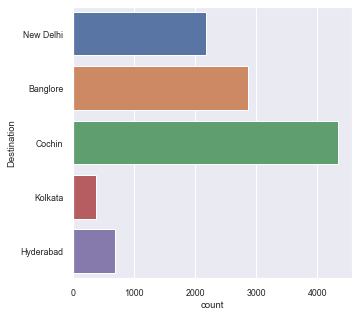

In [36]:
sns.countplot(y=df['Destination'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Month_of_Date_of_Journey'>

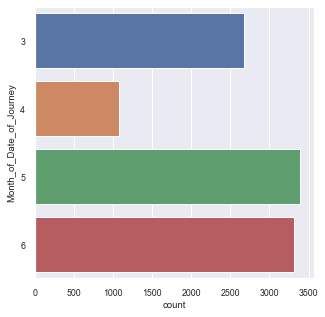

In [37]:
sns.countplot(y=df['Month_of_Date_of_Journey'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Day_Name_of_Date_of_Journey'>

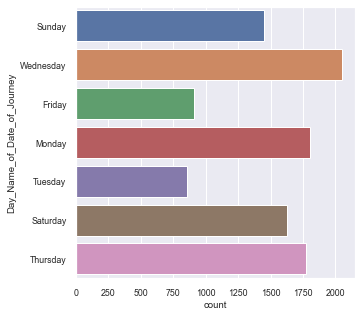

In [38]:
sns.countplot(y=df['Day_Name_of_Date_of_Journey'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Period_of_Date_of_Journey'>

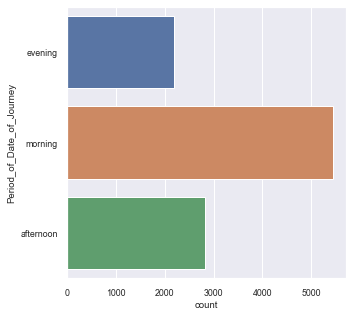

In [39]:
sns.countplot(y=df['Period_of_Date_of_Journey'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Total_Stops'>

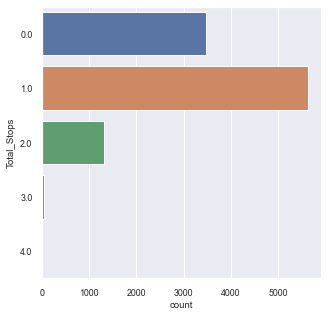

In [40]:
sns.countplot(y=df['Total_Stops'] , data=df)

<AxesSubplot:xlabel='Price', ylabel='Density'>

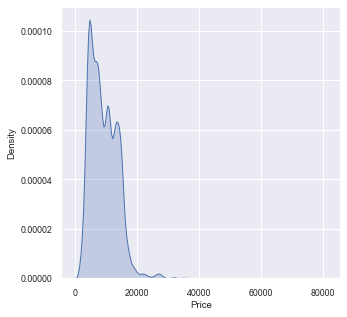

In [41]:
sns.kdeplot(df['Price'] , shade=True)

<AxesSubplot:xlabel='miles', ylabel='Density'>

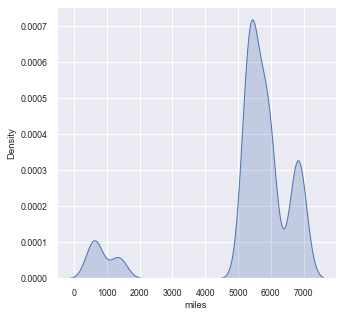

In [42]:
sns.kdeplot(df['miles'] , shade=True)

<AxesSubplot:xlabel='count', ylabel='Airline'>

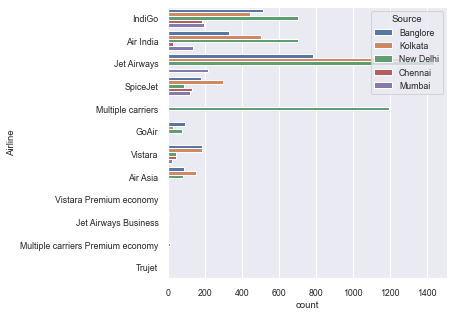

In [43]:
sns.countplot(y=df['Airline'] , hue=df['Source'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Airline'>

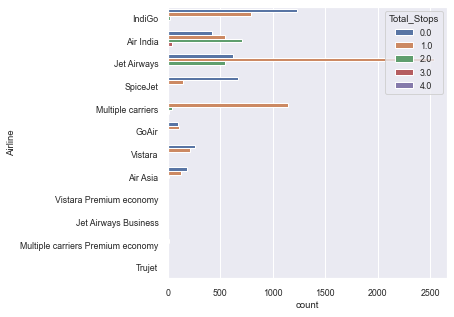

In [44]:
sns.countplot(y=df['Airline'] , hue=df['Total_Stops'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Airline'>

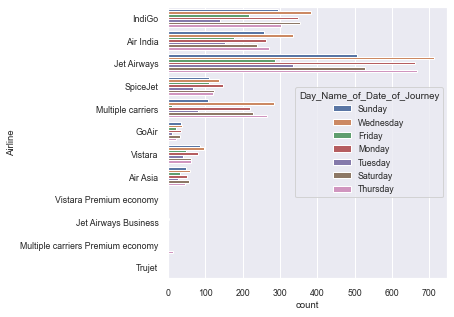

In [45]:
sns.countplot(y=df['Airline'] , hue=df['Day_Name_of_Date_of_Journey'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Airline'>

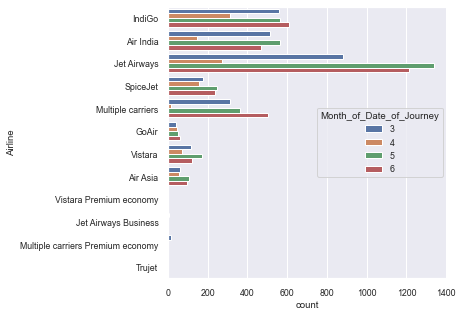

In [46]:
sns.countplot(y=df['Airline'] , hue=df['Month_of_Date_of_Journey'] , data=df)

<AxesSubplot:xlabel='count', ylabel='Airline'>

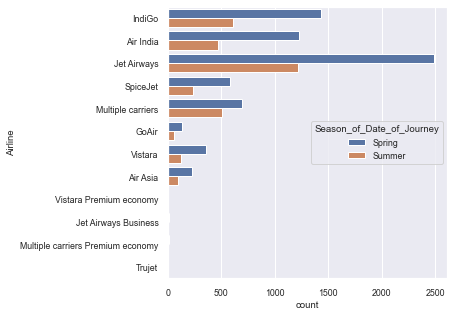

In [47]:
sns.countplot(y=df['Airline'] , hue=df['Season_of_Date_of_Journey'] , data=df)

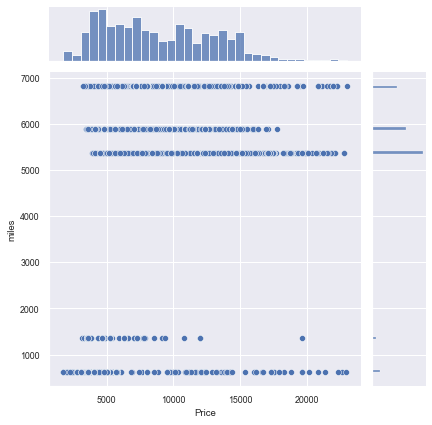

In [78]:
sns.jointplot(y=df['miles'] , x=df['Price'] , data=df)

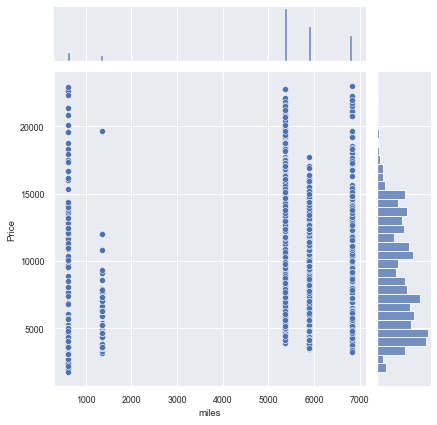

In [76]:
sns.jointplot(y=df['Price'] , x=df['miles'] , data=df)

<AxesSubplot:xlabel='Price', ylabel='Airline'>

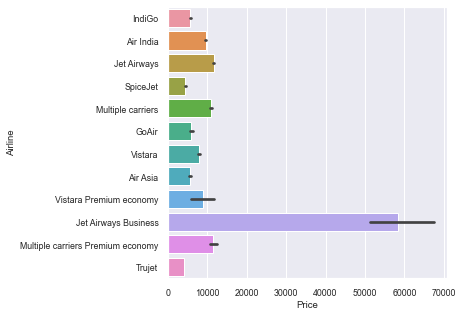

In [50]:
sns.barplot(y=df['Airline'] , x=df['Price'] , data=df)

<AxesSubplot:xlabel='Speed_of_flight_kg/m', ylabel='Airline'>

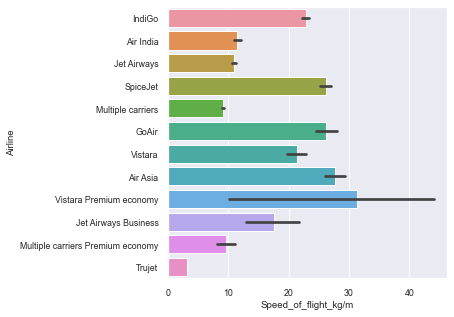

In [51]:
sns.barplot(y=df['Airline'] , x=df['Speed_of_flight_kg/m'] , data=df)

<AxesSubplot:xlabel='Price', ylabel='Airline'>

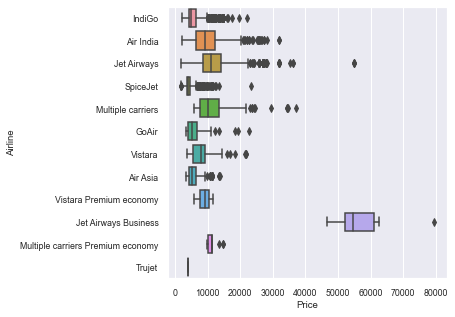

In [52]:
sns.boxplot(y=df['Airline'] , x=df['Price'] , data=df)

<AxesSubplot:xlabel='Day_Name_of_Date_of_Journey', ylabel='Price'>

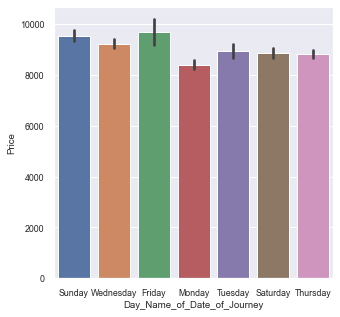

In [53]:
sns.barplot(x=df['Day_Name_of_Date_of_Journey'] , y=df['Price'] , data=df)

<AxesSubplot:xlabel='Period_of_Date_of_Journey', ylabel='Price'>

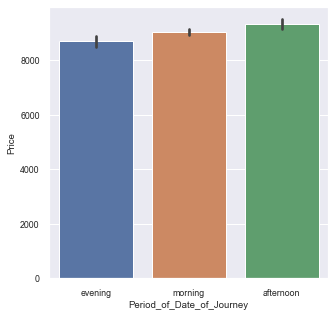

In [54]:
sns.barplot(x=df['Period_of_Date_of_Journey'] , y=df['Price'] , data=df)

<AxesSubplot:xlabel='Season_of_Date_of_Journey', ylabel='Price'>

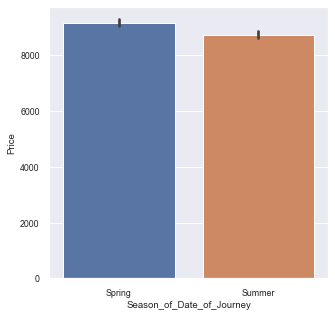

In [55]:
sns.barplot(x=df['Season_of_Date_of_Journey'] , y=df['Price'] , data=df)

<AxesSubplot:xlabel='Month_of_Date_of_Journey', ylabel='Price'>

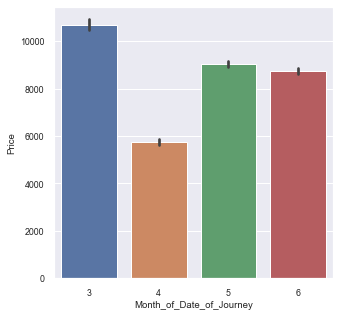

In [56]:
sns.barplot(x=df['Month_of_Date_of_Journey'] , y=df['Price'] , data=df)

<AxesSubplot:xlabel='Day_Name_of_Date_of_Journey', ylabel='count'>

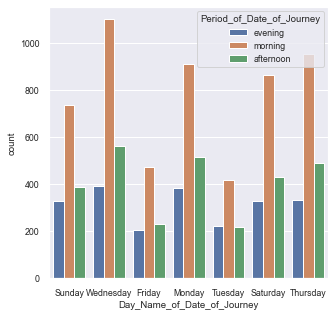

In [57]:
sns.countplot(x=df['Day_Name_of_Date_of_Journey'], hue=df['Period_of_Date_of_Journey'], data=df)

<AxesSubplot:xlabel='count', ylabel='Month_of_Date_of_Journey'>

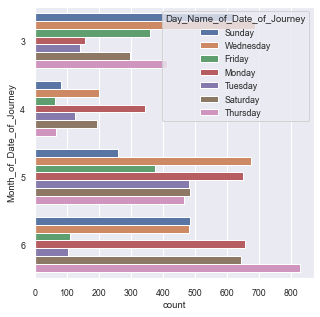

In [58]:
sns.countplot(y=df['Month_of_Date_of_Journey'] , data=df , hue=df['Day_Name_of_Date_of_Journey'])

### PREPARING FOR MODELING

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10460 entries, 0 to 10682
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Airline                        10460 non-null  object        
 1   Date_of_Journey                10460 non-null  datetime64[ns]
 2   Source                         10460 non-null  object        
 3   Destination                    10460 non-null  object        
 4   Route                          10460 non-null  object        
 5   Total_Stops                    10460 non-null  float64       
 6   Additional_Info                10460 non-null  object        
 7   Price                          10460 non-null  int64         
 8   Duration_in_mintues            10460 non-null  float64       
 9   Month_of_Date_of_Journey       10460 non-null  int64         
 10  Month_Name_of_Date_of_Journey  10460 non-null  object        
 11  Day_number_of_D

In [60]:
df['ArrivalHour'] = df['ArrivalHour'] .astype('int64')
df['Duration_in_mintues'] = df['Duration_in_mintues'] .astype('int64')


In [61]:
df.drop(['Day_Name_of_Date_of_Journey','Month_Name_of_Date_of_Journey','Duration_in_mintues','Route'],axis=1,inplace=True)

In [63]:
AdditionalInfoEnc,MealIncludedEnc,Season_of_Date_of_JourneyEnc,Period_of_Date_of_JourneyEnc,FlightLengthEnc =LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()

In [64]:
def ApplyEncoder(Encoder,OriginalColumn) : 
    global data
    Encoder.fit(df[OriginalColumn])
    return Encoder.transform(df[OriginalColumn])

In [65]:
df['AdditionalInfoEnc'] = ApplyEncoder(AdditionalInfoEnc,'Additional_Info')
df['MealIncludedEnc'] = ApplyEncoder(MealIncludedEnc,'Meal Included')
df['Season_of_Date_of_JourneyEnc'] = ApplyEncoder(Season_of_Date_of_JourneyEnc,'Season_of_Date_of_Journey')
df['Period_of_Date_of_JourneyEnc'] = ApplyEncoder(Period_of_Date_of_JourneyEnc,'Period_of_Date_of_Journey')
df['FlightLengthEnc'] = ApplyEncoder(FlightLengthEnc,'FlightLength')

In [66]:
df = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination'], drop_first=True)

In [67]:
df.head(2)

,Date_of_Journey,Total_Stops,Additional_Info,Price,Month_of_Date_of_Journey,Day_number_of_Date_of_Journey,Hour_Date_of_Journey,ArrivalHour,Season_of_Date_of_Journey,Period_of_Date_of_Journey,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Kolkata,Source_Mumbai,Source_New Delhi,Destination_Cochin,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,2019-03-24 22:20:00,0.0,No info,3897,3,24,22,1,Spring,evening,...,0,0,0,0,0,0,0,0,0,1
1,2019-05-01 05:50:00,2.0,No info,7662,5,1,5,13,Spring,morning,...,0,0,0,1,0,0,0,0,0,0


In [68]:
outliers_indices = detect_outliers(df,0,['Price'])
df.drop(outliers_indices,inplace = True)
len(outliers_indices)

94

In [69]:
df.columns

Index(['Date_of_Journey', 'Total_Stops', 'Additional_Info', 'Price',
       'Month_of_Date_of_Journey', 'Day_number_of_Date_of_Journey',
       'Hour_Date_of_Journey', 'ArrivalHour', 'Season_of_Date_of_Journey',
       'Period_of_Date_of_Journey', 'Destination_latitude',
       'Destination_longitude', 'Source_latitude', 'Source_longitude', 'miles',
       'Speed_of_flight_kg/m', 'Meal Included', 'FlightLength',
       'AdditionalInfoEnc', 'MealIncludedEnc', 'Season_of_Date_of_JourneyEnc',
       'Period_of_Date_of_JourneyEnc', 'FlightLengthEnc', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Kolkata', 'Source_Mumbai', 'Source_New Delhi',
       'Destination_Cochin', 'Destination_Hyderabad', 'Destina

### splitting data

In [70]:
x = df[['Total_Stops', 'Month_of_Date_of_Journey','Day_number_of_Date_of_Journey', 'miles',
        'Speed_of_flight_kg/m', 'Meal Included', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Kolkata', 'Source_Mumbai', 'Source_New Delhi',
       'Destination_Cochin', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi', 'AdditionalInfoEnc','MealIncludedEnc', 'Season_of_Date_of_JourneyEnc',
       'Period_of_Date_of_JourneyEnc', 'FlightLengthEnc']]
y = df['Price']

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=5)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8292, 30)
(2074, 30)
(8292,)
(2074,)


In [72]:
columns = ['miles','Speed_of_flight_kg/m']
scaler = StandardScaler()

scaler.fit(x_train[columns])

x_train[columns] = scaler.transform(x_train[columns])
x_test[columns] = scaler.transform(x_test[columns])

In [73]:
models = {
    'LR': LinearRegression(),
    'DT': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'SVM': SVR(), 
    'RF': RandomForestRegressor(),
    'XGB': XGBRegressor()
}

for name, model in models.items():
    print(f'Traing {name}...')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_tr = model.predict(x_train)
    print(f'Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_tr))}')
    print(f'Training MAE: {mean_absolute_error(y_train, y_pred_tr)}')
    print(f'Training R2: {r2_score(y_train, y_pred_tr)}')
    print('++++++')
    print(f'Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'Testing MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'Testing R2: {r2_score(y_test, y_pred)}')
    print('-'*50)

Traing LR...
Training RMSE: 2216.7721619149497
Training MAE: 1638.86526274822
Training R2: 0.703206429366177
++++++
Testing RMSE: 2166.6247256690494
Testing MAE: 1633.4261997027606
Testing R2: 0.7164260424479408
--------------------------------------------------
Traing DT...
Training RMSE: 435.2885060302777
Training MAE: 105.7756472101624
Training R2: 0.9885562919418004
++++++
Testing RMSE: 1654.7775436781208
Testing MAE: 848.9108003857281
Testing R2: 0.8345837422619454
--------------------------------------------------
Traing KNN...
Training RMSE: 1505.1682061512229
Training MAE: 936.3737578388809
Training R2: 0.8631696483950033
++++++
Testing RMSE: 1902.7247489280262
Testing MAE: 1214.195274831244
Testing R2: 0.7812989397765099
--------------------------------------------------
Traing SVM...
Training RMSE: 4059.849405112722
Training MAE: 3395.68610518976
Training R2: 0.004520733032536417
++++++
Testing RMSE: 4045.1284881488386
Testing MAE: 3367.4380664310474
Testing R2: 0.01152976547

In [74]:
SelectedModel = XGBRegressor(random_state=33)
SelectedParameters = {'n_estimators':[100,200,500,1000],'max_depth':[2,4,8,10],
                      'criterion':['squared_error','absolute_error','poisson']}



GridSearchModel = GridSearchCV(SelectedModel,SelectedParameters,
                               cv = 2,return_train_score=True)
GridSearchModel.fit(x_train, y_train)
sorted(GridSearchModel.cv_results_.keys())
GridSearchResults = pd.DataFrame(GridSearchModel.cv_results_)[
    ['mean_test_score','std_test_score','params','rank_test_score','mean_fit_time']]

# Showing Results
print('All Results are :\n', GridSearchResults )
print('Best Score is :', GridSearchModel.best_score_)
print('Best Parameters are :', GridSearchModel.best_params_)
print('Best Estimator is :', GridSearchModel.best_estimator_)

[20:05:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could b

[20:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could b

[20:06:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could b

[20:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could b

[20:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "criterion" } might not be used.

  This could b

so default parameters of XGB model is the best acc